# Previsão Perfil de Usuários Aprendizap
A seguir será realizado uma análise dos dados dos professores usuários cadastrados na plataforma do AprendiZap.

**Objetivo:** Criar previsões sobre o perfil dos usuários professores que utilizam o AprendiZap, através de algorítmos de Machine Learning.

##  1.Configurações iniciais

Instalando dependências que não estão no windows.

In [88]:
!pip install shap
!pip install xgboost
!pip install -U scikit-learn umap-learn

Configuração das bibliotecas e import dos dados.

In [89]:
from datetime import datetime, timezone
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import altair as alt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, MultiLabelBinarizer, OneHotEncoder, FunctionTransformer
from xgboost import XGBRegressor, plot_importance
import xgboost as xgb
import shap
import umap

import matplotlib.pyplot as plt
import seaborn as sns

In [90]:
df_teachers_entries = pd.read_parquet("../data-raw/teachers_entries.parquet")

In [91]:
list(df_teachers_entries.columns)

['unique_id',
 'profid',
 'utm_origin',
 'tela_origem',
 'estado',
 'total_alunos',
 'login_google',
 'currentstage',
 'currentsubject',
 'selectedstages',
 'selectedsubjectsem',
 'selectedsubjectsfundii',
 'visualizou_metodologia_ativa',
 'data_entrada',
 'Recency',
 'Frequency',
 'Duration',
 'R_score',
 'F_score',
 'M_score',
 'RFM_Segment',
 'RFM_Score',
 'semana_entrada']

## 2. Engenharia de Features

### 2.1. Removendo usuários que não foram considerados válidos.
Os usuários considerados válidos serãoo apenas aqueles que preencheram o campo `selectedstages`, em que o professor precisa selecionar se ensinará no Ensino Médio ou Fundamental. É o último campo obrigatório do cadastro, portanto, se não foi um campo completado pelo usuário em cadastro, então assume-se que o usuário nunca utilizou a plataforma realmente.

In [92]:
# filtrar usuários com "selectedstages" sem NA
print(df_teachers_entries.shape)
df_valid_entries=df_teachers_entries[df_teachers_entries['selectedstages'].notna()]
print(df_valid_entries.shape)

(1315970, 23)
(141069, 23)


Observa-se uma redução de 1.315.970 usuários para 141.069.

### 2.2. Removendo Outliers
Foi necessário remover _outliers_ pois foram detectados ao menos 2 usuários com uma utilização anormal da plataforma. Provavelmente BOTS de testes ou outras excesões que podem contaminar o processo.

In [93]:
print(df_valid_entries.shape)
# Remover outliers na coluna "Duration"
limite_inferior = df_valid_entries["Duration"].quantile(0.0001)
limite_superior = df_valid_entries["Duration"].quantile(1 - 0.0001)

# Filtrar dados
df_no_outliers = df_valid_entries[(df_valid_entries["Duration"] >= limite_inferior) & (df_valid_entries["Duration"] <= limite_superior)]
print(df_no_outliers.shape)

(141069, 23)
(141054, 23)


### 2.3. Definindo Escopo inicial
Inicialmente a hipótese primária levará as seguintes colunas em consideração para o modelo de inteligência artificial.

- Colunas desconsideradas para o modelo: `unique_id`,`profid`,`R_Score`,`F_Score`,`M_Score`,`RFM_Segment`,`RFM_Score`,`semana_entrada`.

- Colunas para transformar em preditora categórica: `utm_origin`,`tela_origem`,`login_google`,`estado`,`currentstage`,`currentsubject`,`selectedstages`,`selectedsubjectsem`,`selectedsubjectsfundii`,`visualizou_metodologia_ativa`.

- Colunas para serem normalizadas: `total_alunos`,`Recency`,`Frequency`.

- Coluna alvo: `Duration`.

### 2.4. Ajustando variáveis categóricas
Nesta secção serão regularizadas as colunas categóricas, pois possuem uma série de problemas ao serem analisadas por modelos preditivos. Antes, será plotado uma contagem de todos os dados do dataframe para melhor visualização.

Primeiramente, repara-se que login_google possui 2 categorias que deveriam ser binárias, mas como está registrada como `float`, apenas vemos os casos `True`.
As colunas convertidas são `login_google` e `visualizou_metodologia_ativa`.

In [94]:
# Convertendo login_google e visualizou_metodologia_ativa para booleano
df_categ_step = df_no_outliers.copy()
df_categ_step['login_google'] = df_categ_step['login_google'].apply(lambda x: True if x == 1.0 else False)
df_categ_step['visualizou_metodologia_ativa'] = df_categ_step['visualizou_metodologia_ativa'].apply(lambda x: True if x == 1.0 else False)

Também é visível que em `currentstage` temos categorias redundantes, como por exemplo `em` / `ensino_medio`, e `fundii` / `ensino_fundamental_2`. Portanto essas categorias serão agrupadas.

In [95]:
# Agrupando valores equivalentes em currentstage
df_categ_step['currentstage'] = df_categ_step['currentstage'].replace({
    'ensino_medio': 'em',
    'ensino_fundamental_2': 'fundii'
})

Abaixo é realizado a normalização de colunas `selectedsubjectsem` e `selectedsubjectsfundii`, que são colunas cujos valores são **listas** com as matérias selecionadas por cada professor cadastrado.

Desta forma, o que é necessário, é convertê-las para uma diversidade de linhas booleanas, com True, para as matérias selecionadas.

Exemplo: se um professor está cadastrado nas matérias [1,2,português], será criado 3 colunas `selectedsubjectsem_1`, `selectedsubjectsem_2` e `selectedsubjectsem_português`, nas quais este usuário terá valor `True`.

In [96]:
# Convertendo colunas vazias para listas vazias '[]'.
df_categ_step['selectedsubjectsfundii'] = df_categ_step['selectedsubjectsfundii'].apply(lambda x: x if pd.notna(x) else '[]')
df_categ_step['selectedsubjectsem'] = df_categ_step['selectedsubjectsem'].apply(lambda x: x if pd.notna(x) else '[]')

In [97]:
# Criando função para converter string para lista
def str_to_list(s):
    # remove colchetes e espaços extras
    s_clean = s.strip("[]").replace(" ", "")
    if not s_clean:  # caso esteja vazio
        return []
    # separa por vírgula
    items = s_clean.split(",")
    # tenta converter para int se for número, senão mantém como string
    lista = []
    for i in items:
        lista.append(str(i))
    return lista


# Criando função para expandir colunas de listas em múltiplas colunas booleanas
def expand_str_list_column(df, column):
    
    mlb = MultiLabelBinarizer()
    encoded = mlb.fit_transform(df[column])
    encoded_df = pd.DataFrame(
        encoded,
        columns=[f"{column}_{str(c)}" for c in mlb.classes_],
        index=df.index
    )
    return pd.concat([df, encoded_df], axis=1)

In [98]:
# Aplicando as funções na coluna selectedsubjectsem
df_categ_step['selectedsubjectsem'] = df_categ_step['selectedsubjectsem'].apply(str_to_list)
df_categ_step = expand_str_list_column(df_categ_step, "selectedsubjectsem")

In [99]:
# Aplicando as funções na coluna selectedsubjectsfundii
df_categ_step['selectedsubjectsfundii'] = df_categ_step['selectedsubjectsfundii'].apply(str_to_list)
df_categ_step = expand_str_list_column(df_categ_step, "selectedsubjectsfundii")

Enfim, todas as colunas categóricas são convertidas em tipos como _category_. Isso será utilizado no pipeline de Machine Learning para criar o One Hot Encoder.

In [100]:
# Convertendo colunas categóricas para o tipo 'category'
cat_cols = ['utm_origin','tela_origem','estado','login_google','currentstage','currentsubject',
            'selectedstages','visualizou_metodologia_ativa']

for col in cat_cols:
    df_categ_step[col] = df_categ_step[col].astype('category')

### 2.5. Ajustando variáveis numéricas
Há 3 variáveis numéricas que precisam de normalizações: `total_alunos`, `Frequency` e `Recency`.

In [101]:
df_num_step = df_categ_step.copy()

Primeiro será tratado o `total_alunos`. Pelo _describe_ observa-se que possui valores negativos e também uma concentração grande de alunos em valores mais baixos, com outliers.

In [102]:
df_num_step['total_alunos'].describe()

count    118816.000000
mean         40.141513
std          68.478662
min         -60.000000
25%          10.000000
50%          30.000000
75%          40.000000
max         999.000000
Name: total_alunos, dtype: float64

In [103]:
# Professores com número negativo de alunos são transformados em 0
df_num_step['total_alunos'] = df_num_step['total_alunos'].apply(lambda x: 0 if x < 0 else x)

In [104]:
# A seguir será aplicado o StandardScaler para normalizar a coluna total_alunos
std_scaler = StandardScaler()
df_num_step['total_alunos_std'] = std_scaler.fit_transform(df_num_step[['total_alunos']])

A seguir, a coluna `Recency` e `Frequency` serão normalizadas:

In [105]:
# A seguir será aplicado o RobustScaler para normalizar as colunas Recency e Frequency
robust_scaler = RobustScaler()
df_num_step['Recency_robust'] = robust_scaler.fit_transform(df_num_step[['Recency']])
df_num_step['Frequency_robust'] = robust_scaler.fit_transform(df_num_step[['Frequency']])

### 2.6. Ajustando variável temporal
A variável temporal precisa ser transformado em uma componente de cíclica de oscilação

In [106]:
df_temp_step = df_num_step.copy()

In [107]:
# Componentes cíclicas para dias da semana (0=segunda, 6=domingo)
df_temp_step['weekday_entrada'] = df_temp_step['data_entrada'].dt.weekday
df_temp_step['weekday_sin_entrada'] = np.sin(2 * np.pi * df_temp_step['weekday_entrada']/7)
df_temp_step['weekday_cos_entrada'] = np.cos(2 * np.pi * df_temp_step['weekday_entrada']/7)

# Componentes cíclicas para meses do ano (1=Janeiro, 12=Dezembro)
df_temp_step['month_entrada'] = df_temp_step['data_entrada'].dt.month
df_temp_step['month_sin_entrada'] = np.sin(2 * np.pi * (df_temp_step['month_entrada']-1)/12)
df_temp_step['month_cos_entrada'] = np.cos(2 * np.pi * (df_temp_step['month_entrada']-1)/12)

Basicamente, a data de entrada do usuário é convertida em 4 colunas mais importantes: dia da semana e mês do ano. Por que isso? Pois os modelos de machine learning não entendem as datas com a periodicidade que as pessoas. Em outras palavras, final de dezembro é bem perto de janeiro, assim como domingo está perto de segunda-feira, mas para o computador, janeiro/dezembro, domingo/segunda, estariam em pontas opostas. Por isso é importante adicionar as componentes cíclicas de Cosseno e Seno.

É importante adicionar tanto a componente Cosseno, tanto quanto a Seno, pois são estas 2 preditoras que criam o ciclo de oscilação do calendário.

### 2.7. Excluindo colunas desnecessárias

In [108]:
# 2.7. Excluindo colunas desnecessárias
cols_to_drop = ['unique_id','profid','R_score','F_score','M_score','RFM_Segment','RFM_Score',
                'semana_entrada','data_entrada','total_alunos','Recency','Frequency',
                'weekday_entrada','month_entrada','selectedsubjectsfundii','selectedsubjectsem']
df_dropped = df_temp_step.drop(columns=cols_to_drop)

In [109]:
df_dropped.columns

Index(['utm_origin', 'tela_origem', 'estado', 'login_google', 'currentstage',
       'currentsubject', 'selectedstages', 'visualizou_metodologia_ativa',
       'Duration', 'selectedsubjectsem_1', 'selectedsubjectsem_2',
       'selectedsubjectsem_3', 'selectedsubjectsem_4', 'selectedsubjectsem_5',
       'selectedsubjectsem_6', 'selectedsubjectsem_7', 'selectedsubjectsem_8',
       'selectedsubjectsem_ciencias', 'selectedsubjectsem_humanas',
       'selectedsubjectsem_linguagens', 'selectedsubjectsem_matematica',
       'selectedsubjectsem_vida', 'selectedsubjectsfundii_1',
       'selectedsubjectsfundii_2', 'selectedsubjectsfundii_3',
       'selectedsubjectsfundii_4', 'selectedsubjectsfundii_5',
       'selectedsubjectsfundii_6', 'selectedsubjectsfundii_7',
       'total_alunos_std', 'Recency_robust', 'Frequency_robust',
       'weekday_sin_entrada', 'weekday_cos_entrada', 'month_sin_entrada',
       'month_cos_entrada'],
      dtype='object')

In [110]:
df_dropped.head()

,utm_origin,tela_origem,estado,login_google,currentstage,currentsubject,selectedstages,visualizou_metodologia_ativa,Duration,selectedsubjectsem_1,...,selectedsubjectsfundii_5,selectedsubjectsfundii_6,selectedsubjectsfundii_7,total_alunos_std,Recency_robust,Frequency_robust,weekday_sin_entrada,weekday_cos_entrada,month_sin_entrada,month_cos_entrada
0,Landing Page,Tela inicial,MG,False,fundii,1,[fundii],False,2.247167,0,...,0,0,0,-0.148220,0.025692,-0.25,0.000000,1.000000,8.660254e-01,0.500000
1,Landing Page,Tela inicial,PE,False,em,5,[em],False,1.371333,0,...,0,0,0,-0.002177,0.245684,-0.25,0.433884,-0.900969,-8.660254e-01,0.500000
2,Landing Page,Tela inicial,MT,False,em,4,"[em, fundii]",False,19.604683,0,...,0,1,0,-0.586351,0.022481,0.25,0.781831,0.623490,5.000000e-01,0.866025
3,Landing Page,Tela inicial,MS,False,fundii,1,"[em, fundii]",False,2.989183,1,...,0,0,0,-0.148220,0.385387,-0.25,0.000000,1.000000,-5.000000e-01,-0.866025
4,Não identificado,Tela inicial,SP,False,fundii,4,[fundii],True,4.288583,0,...,0,0,0,-0.586351,-0.163790,-0.25,-0.974928,-0.222521,1.224647e-16,-1.000000


### 2.8. Pré-processamento

Enfim, antes do pipeline de Machine Learning é necessário separar as colunas entre variáveis categóricas, numéricas, temporais e booleanas, para o pré-processamento.

In [111]:
cat_cols = ['utm_origin','tela_origem','estado','currentstage','currentsubject',
            'selectedstages']
num_cols = ['total_alunos_std','Recency_robust','Frequency_robust']
temp_cols = ['weekday_sin_entrada','weekday_cos_entrada',
             'month_sin_entrada','month_cos_entrada']
bool_cols = ['visualizou_metodologia_ativa','login_google',
       'selectedsubjectsem_1', 'selectedsubjectsem_2',
       'selectedsubjectsem_3', 'selectedsubjectsem_4', 'selectedsubjectsem_5',
       'selectedsubjectsem_6', 'selectedsubjectsem_7', 'selectedsubjectsem_8',
       'selectedsubjectsem_ciencias', 'selectedsubjectsem_humanas',
       'selectedsubjectsem_linguagens', 'selectedsubjectsem_matematica',
       'selectedsubjectsem_vida', 'selectedsubjectsfundii_1',
       'selectedsubjectsfundii_2', 'selectedsubjectsfundii_3',
       'selectedsubjectsfundii_4', 'selectedsubjectsfundii_5',
       'selectedsubjectsfundii_6', 'selectedsubjectsfundii_7']
target_col = 'Duration'

Agora, criamos um transformador. Em variáveis categóricas, ele fará o `OneHotEncoder`. Nas numéricas, a transformação de normalização já foi feita, e nas variáveis temporais e booleanas, tudo já está em ordem.

In [113]:
# Pré-processador com SimpleImputer para lidar com possíveis NaNs sem excluí-los
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols),
        
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
            ("scaler", StandardScaler())
        ]), num_cols),
        
        ("temp", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value=0))
        ]), temp_cols),
        
        ("bool", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value=0))
        ]), bool_cols)
    ],
    remainder="drop"
)

In [150]:
# Criando um dataframe que conterá todas as previsões para cada usuário
df_ml = df_no_outliers.copy()

## 3. M.L. Pipeline: Random Forest Regressor

Neste item será realizado a análise de Machine Learning de alguns modelos:
- RandomForestRegressor

### 3.1. Criação do Pipeline de M.L.

Separa-se entre Treino e Teste.

In [115]:
# Cria X e Y, removendo a coluna target_col de X e atribuindo a coluna target_col a y
X = df_dropped.drop(columns=[target_col])
y = df_dropped[target_col]

# Realiza a separação dos dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [116]:
X_train.columns

Index(['utm_origin', 'tela_origem', 'estado', 'login_google', 'currentstage',
       'currentsubject', 'selectedstages', 'visualizou_metodologia_ativa',
       'selectedsubjectsem_1', 'selectedsubjectsem_2', 'selectedsubjectsem_3',
       'selectedsubjectsem_4', 'selectedsubjectsem_5', 'selectedsubjectsem_6',
       'selectedsubjectsem_7', 'selectedsubjectsem_8',
       'selectedsubjectsem_ciencias', 'selectedsubjectsem_humanas',
       'selectedsubjectsem_linguagens', 'selectedsubjectsem_matematica',
       'selectedsubjectsem_vida', 'selectedsubjectsfundii_1',
       'selectedsubjectsfundii_2', 'selectedsubjectsfundii_3',
       'selectedsubjectsfundii_4', 'selectedsubjectsfundii_5',
       'selectedsubjectsfundii_6', 'selectedsubjectsfundii_7',
       'total_alunos_std', 'Recency_robust', 'Frequency_robust',
       'weekday_sin_entrada', 'weekday_cos_entrada', 'month_sin_entrada',
       'month_cos_entrada'],
      dtype='object')

Abaixo, vemos a criação do pipeline de M.L. de um _Random Forest Regressor_.

In [117]:
modelRFR = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

pipelineRFR = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", modelRFR)
])

Na próxima célula, o modelo é treinado e de fato criado, para posteriormente realizar as previsões com os dados separados para teste.

In [118]:
pipelineRFR.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


Com o modelo de RandomForest Regressor treinado, finalmente, realiza-se a previsão com os dados reservados para teste:

In [119]:
y_pred_RFR = pipelineRFR.predict(X_test)

### 3.2. Métricas de Desempenho do Modelo

Em seguida, calcula-se a média absoluta do erro, o RMSE e o R².

In [120]:
print("MAE:", mean_absolute_error(y_test, y_pred_RFR))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_RFR)))
print("R²:", r2_score(y_test, y_pred_RFR))

MAE: 15.379061393199036
RMSE: 48.39918481227647
R²: 0.803373177638525


In [121]:
y_mean = np.full_like(y_test, y.mean(), dtype=float)
print("Baseline MAE:", mean_absolute_error(y_test, y_mean))

Baseline MAE: 36.537720301179135


Mean Absolute Error de uma linha média é maior, o que comprova que o modelo é superior do que uma estimativa precária, como a média.

A seguir, um gráfico de y_test (valores reais corretos) VS y_pred_RFR (valores previstos pelo modelo de RandomForestRegressor) é plotado.
Vê-se que a previsão realizada é capaz de realizar boas estimativas, mas há muitos pontos com erros grandes, apesar destes erros possuírem simetria.

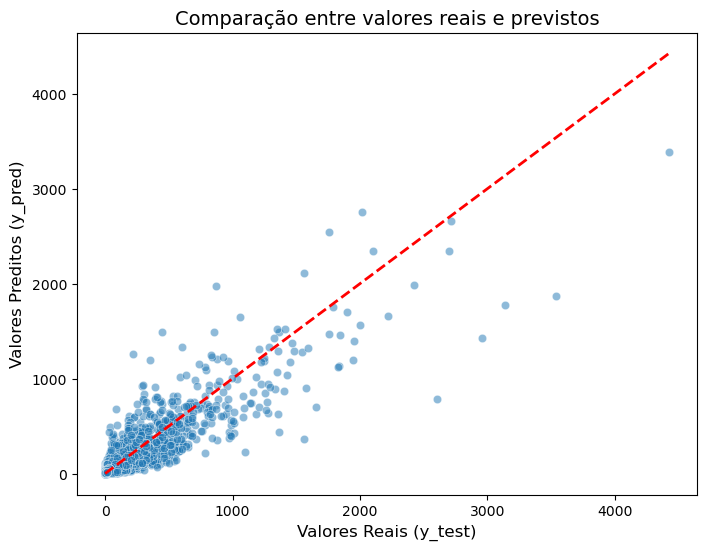

In [122]:
# Previsões
y_pred_RFR = pipelineRFR.predict(X_test)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_RFR, alpha=0.5)

# Linha ideal (y = x)
lims = [min(y_test.min(), y_pred_RFR.min()), max(y_test.max(), y_pred_RFR.max())]
plt.plot(lims, lims, 'r--', lw=2)

plt.xlabel("Valores Reais (y_test)", fontsize=12)
plt.ylabel("Valores Preditos (y_pred)", fontsize=12)
plt.title("Comparação entre valores reais e previstos", fontsize=14)
plt.show()

Um outro gráfico de validação da confiabilidade do modelo preditivo é o gráfico Residual Plot. O objetivo deste gráfico é verificar se os erros estão igualmente distribuídos acima e abaixo da linha vermelha (0). Se não estiverem distribuídos simétricamente , indica que o modelo pode estar inviesado, ou ter _Data Leakage_. Neste caso, parece existir uma boa distribuição. Mas percebe-se erros bem elevados.

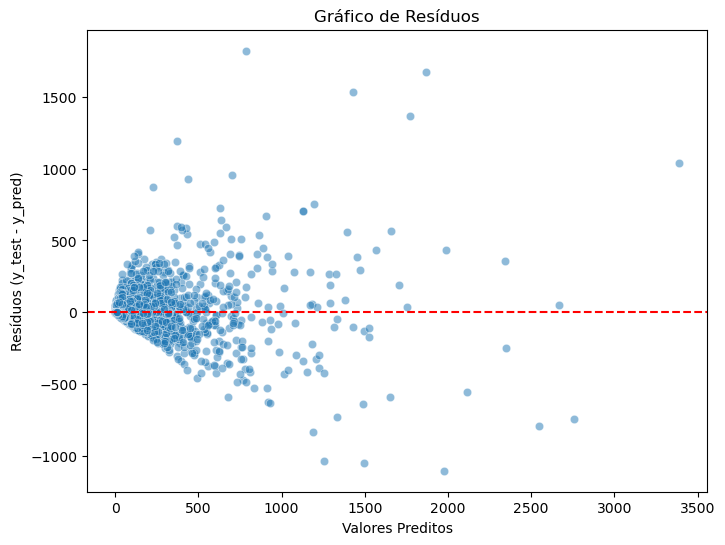

In [123]:
residuos = y_test - y_pred_RFR

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_RFR, y=residuos, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Valores Preditos")
plt.ylabel("Resíduos (y_test - y_pred)")
plt.title("Gráfico de Resíduos")
plt.show()

Agora, será realizado um cross-validation para verificar se o Erro quadrático médio é similar. Isso garante que a amostra de teste/treino não capturaram algum padrão por acaso. Percebe-se que o erro quadrático se mantém constante nos _Folds_, o que indica que não houve viés provocado pela forma como as amostras de treino/teste foram criadas.

In [124]:
scores = cross_val_score(pipelineRFR, X, y, cv=5, scoring="r2")
print("R² médio (CV):", scores.mean())
print("R² por fold:", scores)

R² médio (CV): 0.819742679387972
R² por fold: [0.83261548 0.80826554 0.80175752 0.82646145 0.82961341]


### 3.3. Cross Validation para Hiperparâmetros


**Atenção!**: Como esta etapa é demorada, está comentada (leva cerca de 30 minutos). Na última execução, foi obtido:

Melhores parâmetros:
- 'model__max_depth': 10,
- 'model__min_samples_split': 10,
- 'model__n_estimators': 500

Resultado: Melhor R² de validação: 0.823681691254534

Percebe-se que o R² da interação inicial foi inferior do que o da validação cruzada. Portanto, será mantido os valores da iteração inicial.

In [125]:
'''
param_grid = {
    "model__n_estimators": [100, 200, 500],
    "model__max_depth": [None, 10, 20],
    "model__min_samples_split": [2, 5, 10]
}

search = GridSearchCV(pipeline, param_grid, cv=3, scoring="r2", n_jobs=-1)
search.fit(X_train, y_train)

print("Melhores parâmetros:", search.best_params_)
print("Melhor R² de validação:", search.best_score_)
'''

'\nparam_grid = {\n    "model__n_estimators": [100, 200, 500],\n    "model__max_depth": [None, 10, 20],\n    "model__min_samples_split": [2, 5, 10]\n}\n\nsearch = GridSearchCV(pipeline, param_grid, cv=3, scoring="r2", n_jobs=-1)\nsearch.fit(X_train, y_train)\n\nprint("Melhores parâmetros:", search.best_params_)\nprint("Melhor R² de validação:", search.best_score_)\n'

importances = search.best_estimator_["model"].feature_importances_
feature_names = search.best_estimator_["preprocess"].get_feature_names_out()

feat_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feat_importances.head(20))

### 3.4. Interpretabilidade

Caso você tenha habilitado o GridSearchCV, utilize a próxima célula de código para encontrar os hiperparâmetros adequados. Caso contrário, pule para a próxima célula.

In [126]:
'''
importances = search.best_estimator_["model"].feature_importances_
feature_names = search.best_estimator_["preprocess"].get_feature_names_out()

feat_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feat_importances.head(20))
'''

'\nimportances = search.best_estimator_["model"].feature_importances_\nfeature_names = search.best_estimator_["preprocess"].get_feature_names_out()\n\nfeat_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)\nprint(feat_importances.head(20))\n'

Caso você tenha incorporado o modelo Random Forest com os parâmetros iniciais, utilize as linhas de código abaixo. Aqui é calculado a improtância no modelo de M.L. de cada preditora, seja booleana, temporal, categórica ou numérica. E em seguida, um gráfico será apresentado demonstrando essa importância.

In [127]:
# Acessa o modelo RandomForest já treinado
modelRFR = pipelineRFR["model"]

# Pega as importâncias das features
importances = modelRFR.feature_importances_

# Recupera os nomes das features após transformação
feature_names = pipelineRFR["preprocess"].get_feature_names_out()

# Junta em um DataFrame ou Series para análise
feat_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feat_importances.head(20))


num__Frequency_robust                 0.846598
num__Recency_robust                   0.029522
num__total_alunos_std                 0.014889
temp__weekday_sin_entrada             0.006988
temp__month_cos_entrada               0.006819
temp__month_sin_entrada               0.006663
temp__weekday_cos_entrada             0.004795
bool__visualizou_metodologia_ativa    0.003737
cat__estado_CE                        0.002800
cat__estado_MG                        0.002250
cat__estado_SP                        0.002206
cat__utm_origin_SEO Ads               0.002077
cat__selectedstages_[em, fundii]      0.002027
cat__estado_PA                        0.002002
cat__utm_origin_SEO Orgânico          0.001862
cat__estado_MS                        0.001854
bool__login_google                    0.001749
cat__currentsubject_2                 0.001718
cat__utm_origin_Landing Page          0.001715
bool__selectedsubjectsfundii_6        0.001708
dtype: float64


Plotando um gráfico com as 20 features mais importantes para o modelo RandomForest

C:\Users\ericl\AppData\Local\Temp\ipykernel_19288\3711518734.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")


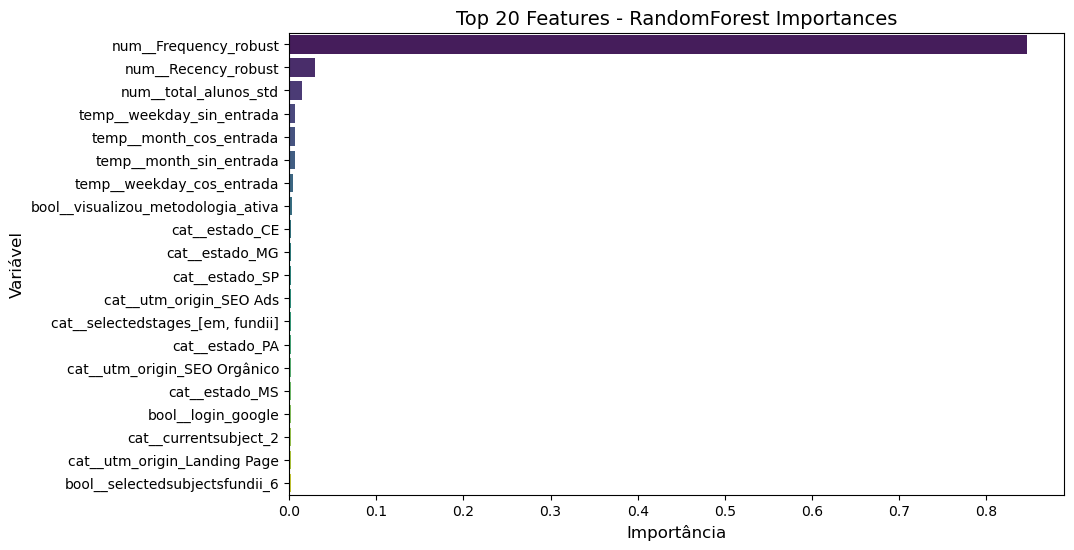

In [128]:
# Seleciona as 20 features mais importantes
top_features = feat_importances.head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index, palette="viridis")

plt.title("Top 20 Features - RandomForest Importances", fontsize=14)
plt.xlabel("Importância", fontsize=12)
plt.ylabel("Variável", fontsize=12)
plt.show()

### 3.5. Adicionando previsões no DF final

In [132]:
# gerar previsões
pred_RFR = pipelineRFR.predict(X)

# adicionar coluna com valores previstos
df_ml["pred_RFR"] = pred_RFR

# Preview
df_ml.head()

,unique_id,profid,utm_origin,tela_origem,estado,total_alunos,login_google,currentstage,currentsubject,selectedstages,...,Recency,Frequency,Duration,R_score,F_score,M_score,RFM_Segment,RFM_Score,semana_entrada,pred_RFR
0,f1dbcf6e-700a-4a9b-aa78-4c53270f929e,None,Landing Page,Tela inicial,MG,30.0,NaN,fundii,1,[fundii],...,871,1,2.247167,2,4,5,245,11,2023-03-20,3.788123
1,0da949a1-b3be-4e4e-8303-b9319d0475ff,None,Landing Page,Tela inicial,PE,40.0,NaN,em,5,[em],...,1008,1,1.371333,1,1,5,115,7,2022-10-31,2.006712
2,a8115c6f-28d9-4231-aae9-f263f08b1919,None,Landing Page,Tela inicial,MT,0.0,NaN,em,4,"[em, fundii]",...,869,3,19.604683,2,5,5,255,12,2023-02-27,17.508007
3,a67cc2f5-95b5-4cb5-9a5b-3766de9be130,None,Landing Page,Tela inicial,MS,30.0,NaN,fundii,1,"[em, fundii]",...,1095,1,2.989183,1,3,5,135,9,2022-08-08,3.295788
4,99bcf296-626c-488e-901a-5cf6a4525fcf,None,Não identificado,Tela inicial,SP,0.0,NaN,fundii,4,[fundii],...,753,1,4.288583,2,3,5,235,10,2023-07-10,4.600059


## 4. M.L. Pipeline: XGBoost

### 4.1. Criação do Pipeline de M.L.

In [ ]:
modelXGB = XGBRegressor(
    n_estimators=500,      # número de árvores
    learning_rate=0.05,    # taxa de aprendizado
    max_depth=6,           # profundidade das árvores
    subsample=0.8,         # fração de amostras por árvore
    colsample_bytree=0.8,  # fração de features por árvore
    random_state=42,
    n_jobs=-1
)

pipelineXGB = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", modelXGB)
])

Em seguida, será criado o modelo de XGBoost com base na amostra de treino criada anteriormete. As amostras criadas no modelo de Random Forest Regression ainda servem aqui, portanto, não realiza-se uma nova separação de treino-teste neste pipeline.

In [42]:
pipelineXGB.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [ ]:
y_pred_XGB = pipelineXGB.predict(X_test)

### 4.2. Métricas de Desempenho do Modelo

Abaixo, calcula-se as métricas R² e RMSE do novo modelo preditivo treinado _XGBoost_. Observa-se que o R² é um pouco melhor do que o do _Random Forest Regressor_. Contudo, há um aumento substancial do RMSE. Ao final do projeto uma tabela comparativa será apresentada.

In [61]:
print("R²:", r2_score(y_test, y_pred_XGB))
rmse = np.sqrt(mean_squared_error(y_test, y_pred_XGB))
print("RMSE:", rmse)

R²: 0.7210810851100866
RMSE: 57.64420446848734


Assim como no _Random Forest Regressor_, será plotado um gráfico `y_pred`vs `y_teste`, para analisar o quão distante a dispersão está da diagonal, e portanto o erro.

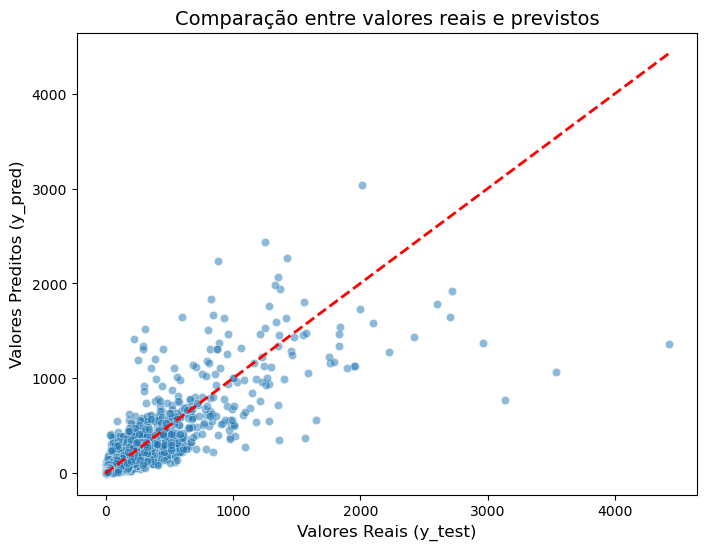

In [62]:
# Previsões
y_pred_XGB = pipelineXGB.predict(X_test)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_XGB, alpha=0.5)

# Linha ideal (y = x)
lims = [min(y_test.min(), y_pred_XGB.min()), max(y_test.max(), y_pred_XGB.max())]
plt.plot(lims, lims, 'r--', lw=2)

plt.xlabel("Valores Reais (y_test)", fontsize=12)
plt.ylabel("Valores Preditos (y_pred)", fontsize=12)
plt.title("Comparação entre valores reais e previstos", fontsize=14)
plt.show()

Ao contrário do Random Forest Regressor, o XGBoost parece trazer um pouco mais de assimetria no Residual Plot, conforme o gráfico abaixo. Isso pode não só indicar um enviezamento, como também justifica um **RMSE** um pouco maior.

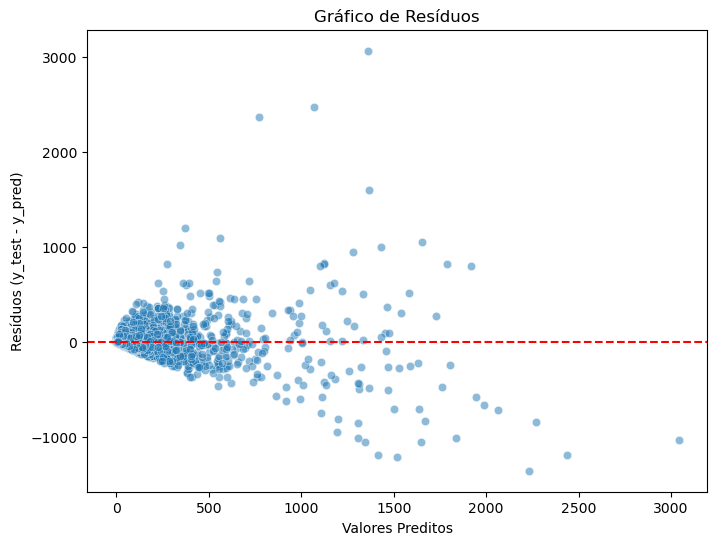

In [63]:
residuos = y_test - y_pred_XGB

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_XGB, y=residuos, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Valores Preditos")
plt.ylabel("Resíduos (y_test - y_pred)")
plt.title("Gráfico de Resíduos")
plt.show()

### 4.3. Cross-validation para Hiperparâmetro

Abaixo, realiza-se um cross validation com 42 camadas. Observa-se um RMSE baixo. O _Test-RMSE-Mean_ está acima do RMSE do treino, indicando que já está no ponto ótimo. Além disso, vemos que o RMSE reduz muito pouco, indicando que por volta da rodada 40, o modelo já está saturado e treiná-lo mais pode provocar overfitting.

In [64]:
# Criar DMatrix com enable_categorical se tiver colunas categóricas
dtrain = xgb.DMatrix(X, label=y, enable_categorical=True)

params = {
    "objective": "reg:squarederror",
    "tree_method": "hist",
    "max_depth": 6,
    "eta": 0.1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "random_state": 42
}

# Cross-validation com 5 folds
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=500,
    nfold=5,
    metrics="rmse",
    early_stopping_rounds=20,
    seed=42
)

print(cv_results.tail())

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
38        36.210765        0.345580       55.054905       3.620299
39        35.983877        0.402439       55.016695       3.600362
40        35.661139        0.409514       55.005593       3.692138
41        35.579796        0.384595       55.021731       3.688409
42        35.353981        0.360738       54.995069       3.743100


### 4.4. Interpretabilidade

**Abaixo realiza-se um plot do gráfico SHAP, de interpretabilidade do modelo XGBoost.**

Cada linha é uma feature do modelo. A ordem é da mais importante (topo) para a menos importante (embaixo). Valores positivos (direita) empurram a previsão para cima (↑). Valores negativos (esquerda) empurram a previsão para baixo (↓). Quanto a cor: Azul → valor baixo daquela variável.Vermelho → valor alto daquela variável. Cada ponto é uma observação (linha do seu dataset).

A dispersão mostra a variação do efeito daquela variável entre os registros.

**O que pode-se concluir:**
- As variáveis de engajamento direto (Frequency, Recency, visualizou_metodologia_ativa) são as mais fortes preditoras.

- Variáveis de origem de tráfego também influenciam, mas menos.

- Variáveis temporais e matérias selecionadas têm impacto, mas pequeno.

C:\Users\ericl\AppData\Local\Temp\ipykernel_19288\1933302434.py:11: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_transformed, feature_names=preprocessor.get_feature_names_out())


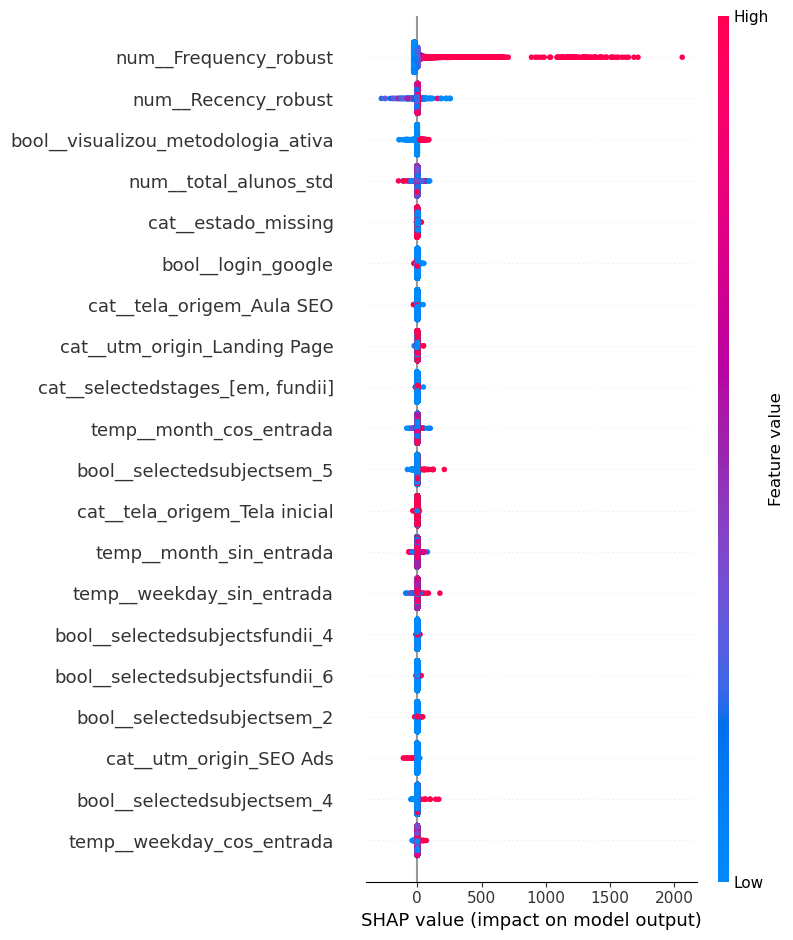

In [65]:
# Explicador baseado no modelo treinado
explainer = shap.TreeExplainer(modelXGB)

# Transformar X_test com o pipeline antes de passar para o SHAP
X_test_transformed = preprocessor.transform(X_test)

# Calcular os valores SHAP
shap_values = explainer.shap_values(X_test_transformed)

# Plotar resumo
shap.summary_plot(shap_values, X_test_transformed, feature_names=preprocessor.get_feature_names_out())

### 4.5. Adicionando previsões no DF Final

In [134]:
# gerar previsões
pred_XGB = pipelineXGB.predict(X)

# adicionar coluna com valores previstos
df_ml["pred_XGB"] = pred_XGB

# Preview
df_ml.head()

,unique_id,profid,utm_origin,tela_origem,estado,total_alunos,login_google,currentstage,currentsubject,selectedstages,...,Frequency,Duration,R_score,F_score,M_score,RFM_Segment,RFM_Score,semana_entrada,pred_RFR,pred_XGB
0,f1dbcf6e-700a-4a9b-aa78-4c53270f929e,None,Landing Page,Tela inicial,MG,30.0,NaN,fundii,1,[fundii],...,1,2.247167,2,4,5,245,11,2023-03-20,3.788123,3.703282
1,0da949a1-b3be-4e4e-8303-b9319d0475ff,None,Landing Page,Tela inicial,PE,40.0,NaN,em,5,[em],...,1,1.371333,1,1,5,115,7,2022-10-31,2.006712,5.361179
2,a8115c6f-28d9-4231-aae9-f263f08b1919,None,Landing Page,Tela inicial,MT,0.0,NaN,em,4,"[em, fundii]",...,3,19.604683,2,5,5,255,12,2023-02-27,17.508007,11.121158
3,a67cc2f5-95b5-4cb5-9a5b-3766de9be130,None,Landing Page,Tela inicial,MS,30.0,NaN,fundii,1,"[em, fundii]",...,1,2.989183,1,3,5,135,9,2022-08-08,3.295788,5.704005
4,99bcf296-626c-488e-901a-5cf6a4525fcf,None,Não identificado,Tela inicial,SP,0.0,NaN,fundii,4,[fundii],...,1,4.288583,2,3,5,235,10,2023-07-10,4.600059,14.195204


## 5. M.L. Pipeline: Clusterização K-Means

Nesta secção será analisando um machine-learning não-supervisionado para segmentar a base de dados em grupos de usuários. Espera-se que seja identificado aqueles com maior engajamento.

### 5.1. Criação do Pipeline de M.L.

In [ ]:
# Copia do df (segurança)
df_cluster = df_dropped.copy()

# Garantir booleanos como int
df_cluster[bool_cols] = df_cluster[bool_cols].astype(int)

In [183]:
# Pipeline: preproc -> redução dimensional (TruncatedSVD é bom quando OHE dá matriz possivelmente esparsa)

pipelineKMN = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("svd", TruncatedSVD(n_components=25, random_state=42)) # ajuste: 10-50 costuma ser bom; prob. testar
])

In [184]:
# Aplica para obter embeddings (features reduzidas para clustering)
X_KMN = pipelineKMN.fit_transform(df_cluster)

### 5.2. Cross-validation para Hiperparâmetro

Na próxima célula, é criada uma função para teste de hiperparâmetros. Contudo, exige alta capacidade computacional e é uma célula de longa duração para a execução, portanto ela permanecerá em forma de comentário (Estima-se cerca de 1 hora para execução em um Notebook intermediário).

Os dados obtidos a partir destas célular foram:

| k  | Silhouette | Calinski-Harabasz | Davies-Bouldin |
|----|------------|-------------------|----------------|
|  2 |   0.163309 |        20642.33   |        2.453295 |
|  3 |   0.163233 |        16562.59   |        2.019687 |
|  4 |   0.107271 |        15546.29   |        2.043154 |
|  5 |   0.108126 |        13576.95   |        2.399769 |
|  6 |   0.116352 |        13798.58   |        2.108340 |
|  7 |   0.096689 |        12830.38   |        2.154962 |
|  8 |   0.103720 |        11962.18   |        2.103519 |
|  9 |   0.104497 |        11149.73   |        2.181082 |
| 10 |   0.094384 |        10496.64   |        2.354171 |

O valor de **K** identifica em quantos grupos o modelo de M.L. precisa separar a base de dados. Qunato menor o _Silhouette Score_ melhor o desempenho do modelo ao agrupar os usuários em _K_ grupos.

In [185]:
'''
# === Funções de avaliação e escolha de k (elbow + silhouette) ===
def evaluate_kmeans(X, k_range=range(2,11)):
    results = []
    for k in k_range:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels_k = km.fit_predict(X)
        sil = silhouette_score(X, labels_k)
        ch = calinski_harabasz_score(X, labels_k)
        db = davies_bouldin_score(X, labels_k)
        results.append({"k": k, "silhouette": sil, "calinski_harabasz": ch, "davies_bouldin": db})
    return pd.DataFrame(results)
 '''

'\n# === Funções de avaliação e escolha de k (elbow + silhouette) ===\ndef evaluate_kmeans(X, k_range=range(2,11)):\n    results = []\n    for k in k_range:\n        km = KMeans(n_clusters=k, random_state=42, n_init=10)\n        labels_k = km.fit_predict(X)\n        sil = silhouette_score(X, labels_k)\n        ch = calinski_harabasz_score(X, labels_k)\n        db = davies_bouldin_score(X, labels_k)\n        results.append({"k": k, "silhouette": sil, "calinski_harabasz": ch, "davies_bouldin": db})\n    return pd.DataFrame(results)\n '

In [186]:
'''
# Rodar avaliação
k_range = range(2,11)
res_k = evaluate_kmeans(X_KMN, k_range=k_range)
print(res_k)

'''

'\n# Rodar avaliação\nk_range = range(2,11)\nres_k = evaluate_kmeans(X_KMN, k_range=k_range)\nprint(res_k)\n\n'

In [187]:
'''
# Plot Silhouette vs k
plt.figure(figsize=(8,4))
plt.plot(res_k["k"], res_k["silhouette"], marker='o')
plt.xlabel("k (n_clusters)")
plt.ylabel("Silhouette score")
plt.title("Escolha de k - Silhouette")
plt.grid(True)
plt.show()
'''

'\n# Plot Silhouette vs k\nplt.figure(figsize=(8,4))\nplt.plot(res_k["k"], res_k["silhouette"], marker=\'o\')\nplt.xlabel("k (n_clusters)")\nplt.ylabel("Silhouette score")\nplt.title("Escolha de k - Silhouette")\nplt.grid(True)\nplt.show()\n'

Através do método Silhouette, identifica-se um ganho de desempenho do modelo com 4 clusters.
Como o objetivo deste projeto é identificar usuários mais engajados, será proposto análise de 4 e 2 clusters apenas.

### 5.3. Execução e Interpretabilidade do KMEANS

Agora, com a validação cruzada, observa-se que o número de clusters ideal é estimado em k=4. Por isso, executa-se o modelo de M.L. de Kmeans com a base de treino.

In [188]:
# K com base nos resultados de ajuste do Hiperparâmetro

k = 2  # ajuste conforme a análise acima
kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
labels_k = kmeans.fit_predict(X_KMN)
df_cluster["cluster_kmeans"] = labels_k

Para k=4, o _silhouette score_ é:

In [ ]:
# Silhouette final score for chosen clustering
print("Silhouette KMeans:", silhouette_score(X_KMN, labels_k))

Silhouette KMeans: 0.16329979321372268


#### 5.3.1. UMAP 2D

In [190]:
# Visualização com UMAP 2D
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_KMN)

c:\Users\ericl\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


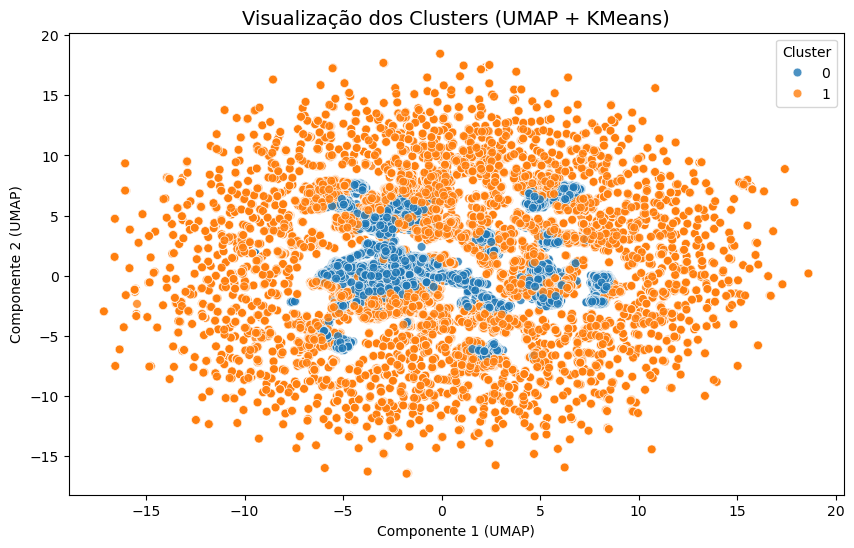

In [191]:
# Criar scatterplot
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_umap[:, 0], 
    y=X_umap[:, 1], 
    hue=labels_k,
    palette="tab10",
    s=40,
    alpha=0.8
)

plt.title("Visualização dos Clusters (UMAP + KMeans)", fontsize=14)
plt.xlabel("Componente 1 (UMAP)")
plt.ylabel("Componente 2 (UMAP)")
plt.legend(title="Cluster")
plt.show()

#### 5.3.2. PCA

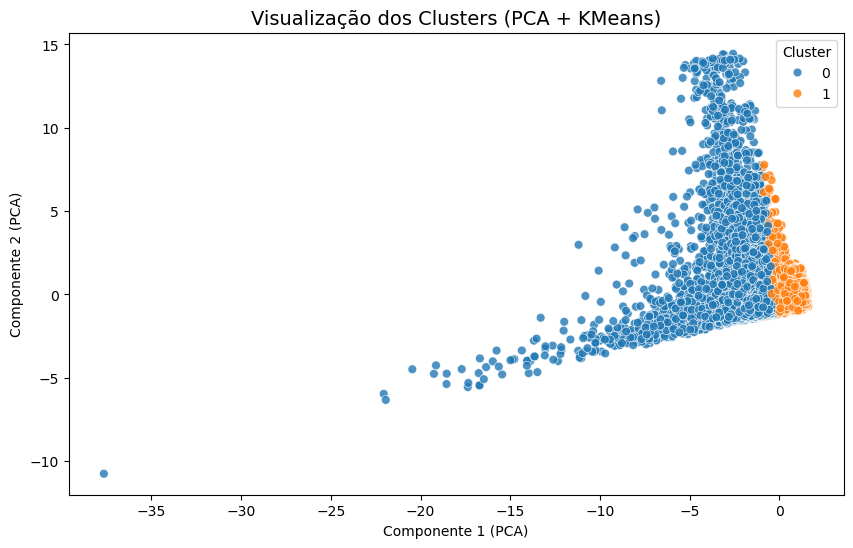

In [192]:
# Reduzir para 2 dimensões com PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_KMN)

# Plotar
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0], 
    y=X_pca[:, 1], 
    hue=labels_k, 
    palette="tab10", 
    s=40, 
    alpha=0.8
)
plt.title("Visualização dos Clusters (PCA + KMeans)", fontsize=14)
plt.xlabel("Componente 1 (PCA)")
plt.ylabel("Componente 2 (PCA)")
plt.legend(title="Cluster")
plt.show()

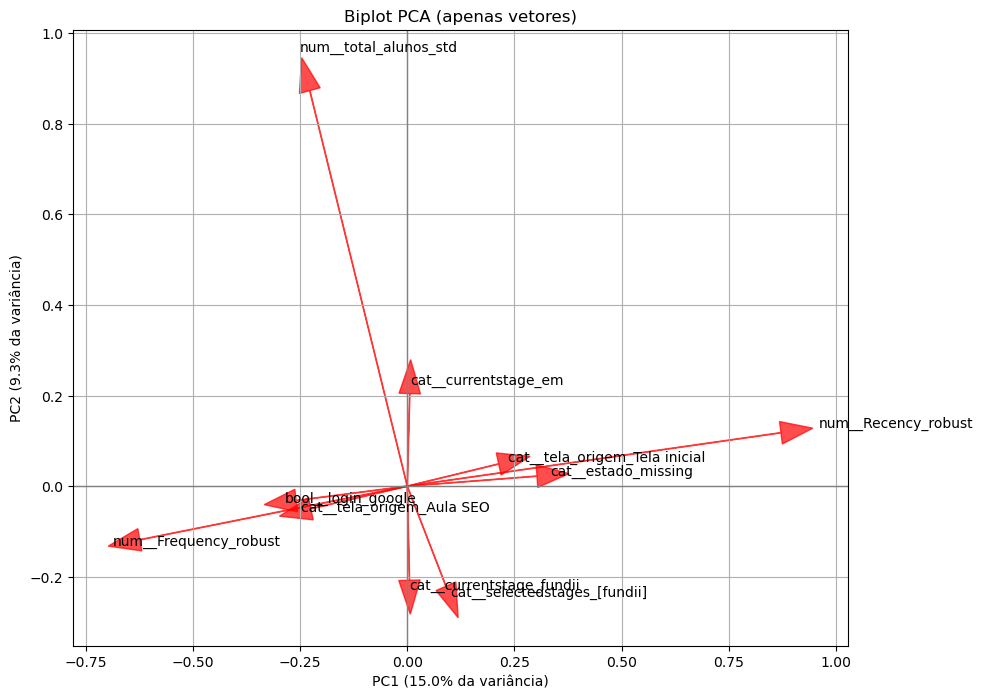

In [193]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

# PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_test_transformed)

# Cargas (loadings)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Selecionar apenas top 10 variáveis com maior norma do vetor
norms = np.linalg.norm(loadings, axis=1)
top_idx = np.argsort(norms)[-10:]

plt.figure(figsize=(10, 8))

# Desenhar setas
for i in top_idx:
    plt.arrow(0, 0, loadings[i, 0], loadings[i, 1],
              color="red", alpha=0.7, head_width=0.05)
    plt.text(loadings[i, 0]*1.1, loadings[i, 1]*1.1,
             feature_names[i], color="black")

plt.axhline(0, color="gray", lw=1)
plt.axvline(0, color="gray", lw=1)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% da variância)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% da variância)")
plt.title("Biplot PCA (apenas vetores)")
plt.grid()
plt.show()


### 5.4. Métricas por Clusters

In [ ]:
# === Perfil dos clusters (summary) ===
def cluster_profile(df, cluster_col, numeric=list(num_cols)+temp_cols):
    prof_num = df.groupby(cluster_col)[numeric].mean().T
    prof_bool = df.groupby(cluster_col)[bool_cols].mean().T
    prof_cat_counts = {}
    # Para algumas categorias OHE grandes é melhor checar percentuais manualmente se quiser
    return prof_num, prof_bool

In [ ]:
prof_num, prof_bool = cluster_profile(df_cluster, "cluster_kmeans")

In [ ]:
print("Numeric means per cluster:")
print(prof_num)

Numeric means per cluster:
cluster_kmeans                        0         1         2         3
selectedsubjectsem_1           0.265296  0.047266  0.336650  0.305921
selectedsubjectsem_2           0.181765  0.025624  0.268242  0.219062
selectedsubjectsem_3           0.206389  0.025336  0.180763  0.177957
selectedsubjectsem_4           0.176055  0.021407  0.252073  0.213291
selectedsubjectsem_5           0.168821  0.021876  0.301824  0.174456
selectedsubjectsem_6           0.171161  0.010505  0.309701  0.062683
selectedsubjectsem_7           0.116225  0.010091  0.194030  0.066320
selectedsubjectsem_8           0.144305  0.015767  0.238391  0.111391
selectedsubjectsem_ciencias    0.000215  0.000775  0.000000  0.006782
selectedsubjectsem_humanas     0.000301  0.001460  0.000000  0.006509
selectedsubjectsem_linguagens  0.000558  0.001838  0.000415  0.007794
selectedsubjectsem_matematica  0.000258  0.000685  0.000000  0.002708
selectedsubjectsem_vida        0.000236  0.000342  0.000829  0.

In [ ]:
print("Boolean means per cluster (fractions):")
print(prof_bool)

Boolean means per cluster (fractions):
cluster_kmeans                        0         1         2         3
visualizou_metodologia_ativa   0.241510  0.015010  0.260365  0.004759
login_google                   0.609463  0.005460  0.555970  0.031670
selectedsubjectsem_1           0.265296  0.047266  0.336650  0.305921
selectedsubjectsem_2           0.181765  0.025624  0.268242  0.219062
selectedsubjectsem_3           0.206389  0.025336  0.180763  0.177957
selectedsubjectsem_4           0.176055  0.021407  0.252073  0.213291
selectedsubjectsem_5           0.168821  0.021876  0.301824  0.174456
selectedsubjectsem_6           0.171161  0.010505  0.309701  0.062683
selectedsubjectsem_7           0.116225  0.010091  0.194030  0.066320
selectedsubjectsem_8           0.144305  0.015767  0.238391  0.111391
selectedsubjectsem_ciencias    0.000215  0.000775  0.000000  0.006782
selectedsubjectsem_humanas     0.000301  0.001460  0.000000  0.006509
selectedsubjectsem_linguagens  0.000558  0.001838  

### 5.5. Adicionando previsões no DF Final

In [194]:
# gerar previsões de Kmeans
X_KMN = pipelineKMN.fit_transform(df_cluster)
k = 2  # ajuste de clusters, conforme ajuste de hiperparâmetro
kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
labels_k = kmeans.fit_predict(X_KMN)

# adicionar coluna com valores previstos
df_ml["pred_KMN"] = labels_k

# Preview
df_ml.head()

,unique_id,profid,utm_origin,tela_origem,estado,total_alunos,login_google,currentstage,currentsubject,selectedstages,...,Recency,Frequency,Duration,R_score,F_score,M_score,RFM_Segment,RFM_Score,semana_entrada,pred_KMN
0,f1dbcf6e-700a-4a9b-aa78-4c53270f929e,None,Landing Page,Tela inicial,MG,30.0,NaN,fundii,1,[fundii],...,871,1,2.247167,2,4,5,245,11,2023-03-20,1
1,0da949a1-b3be-4e4e-8303-b9319d0475ff,None,Landing Page,Tela inicial,PE,40.0,NaN,em,5,[em],...,1008,1,1.371333,1,1,5,115,7,2022-10-31,1
2,a8115c6f-28d9-4231-aae9-f263f08b1919,None,Landing Page,Tela inicial,MT,0.0,NaN,em,4,"[em, fundii]",...,869,3,19.604683,2,5,5,255,12,2023-02-27,1
3,a67cc2f5-95b5-4cb5-9a5b-3766de9be130,None,Landing Page,Tela inicial,MS,30.0,NaN,fundii,1,"[em, fundii]",...,1095,1,2.989183,1,3,5,135,9,2022-08-08,1
4,99bcf296-626c-488e-901a-5cf6a4525fcf,None,Não identificado,Tela inicial,SP,0.0,NaN,fundii,4,[fundii],...,753,1,4.288583,2,3,5,235,10,2023-07-10,1


## 6. M.L. Pipeline com Menos Colunas

In [206]:
# 2.7. Excluindo colunas desnecessárias
cols_to_drop2 = ['unique_id','profid','R_score','F_score','M_score','RFM_Segment','RFM_Score',
                'semana_entrada','data_entrada','total_alunos','Recency','Frequency',
                'weekday_entrada','month_entrada','selectedsubjectsfundii','selectedsubjectsem',
                'weekday_sin_entrada','weekday_cos_entrada','month_sin_entrada','month_cos_entrada','selectedstages'
                ]
df_dropped2 = df_temp_step.drop(columns=cols_to_drop2)

In [207]:
cat_cols2 = ['utm_origin','tela_origem','estado','currentstage','currentsubject']
num_cols2 = ['total_alunos_std','Recency_robust','Frequency_robust','Duration']
bool_cols2 = ['visualizou_metodologia_ativa','login_google']

In [208]:
# Pré-processador com SimpleImputer para lidar com possíveis NaNs sem excluí-los
preprocessor2 = ColumnTransformer(
    transformers=[
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols2),
        
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
            ("scaler", StandardScaler())
        ]), num_cols2),
        
        ("bool", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value=0))
        ]), bool_cols2)
    ],
    remainder="drop"
)

In [209]:
# Copia do df (segurança)
df_cluster2 = df_dropped2.copy()

# Garantir booleanos como int
df_cluster2[bool_cols2] = df_cluster2[bool_cols2].astype(int)

In [210]:
# Pipeline: preproc -> redução dimensional (TruncatedSVD é bom quando OHE dá matriz possivelmente esparsa)

pipelineKMN2 = Pipeline(
    steps=[
        ("preprocess", preprocessor2),
        ("svd", TruncatedSVD(n_components=25, random_state=42)) # ajuste: 10-50 costuma ser bom; prob. testar
])

In [211]:
# Aplica para obter embeddings (features reduzidas para clustering)
X_KMN2 = pipelineKMN2.fit_transform(df_cluster2)

In [ ]:
# K com base nos resultados de ajuste do Hiperparâmetro

k = 2  # ajuste conforme a análise acima
kmeans = KMeans(n_clusters=k, random_state=42, n_init=50)
labels_k2 = kmeans.fit_predict(X_KMN2)
df_cluster2["cluster_kmeans"] = labels_k2

In [213]:
print("Silhouette KMeans:", silhouette_score(X_KMN2, labels_k2))

Silhouette KMeans: 0.25050702524420454


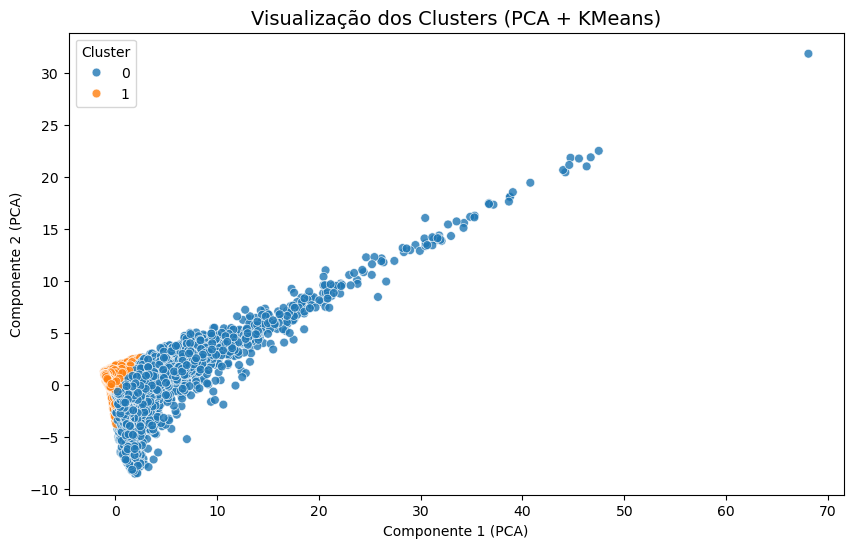

In [214]:
# Reduzir para 2 dimensões com PCA
pca2 = PCA(n_components=2, random_state=42)
X_pca2 = pca2.fit_transform(X_KMN2)

# Plotar
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca2[:, 0], 
    y=X_pca2[:, 1], 
    hue=labels_k2, 
    palette="tab10", 
    s=40, 
    alpha=0.8
)
plt.title("Visualização dos Clusters (PCA + KMeans)", fontsize=14)
plt.xlabel("Componente 1 (PCA)")
plt.ylabel("Componente 2 (PCA)")
plt.legend(title="Cluster")
plt.show()